In [2]:
import cv2
import numpy as np
import pickle
import matplotlib.pyplot as plt

calibration_data = pickle.load(open('calibration_data.p','rb'))

matrix = calibration_data['camera_matrix']
dist_coef = calibration_data['distortion_coefficient']

source_points = [(580, 460), (205, 720), (1110, 720), (703, 460)]
dest_points = [(320, 0), (320, 720), (960, 720), (960, 0)]

warp_matrix = cv2.getPerspectiveTransform(np.float32(source_points), np.float32(dest_points))
inv_warp_matrix = cv2.getPerspectiveTransform(np.float32(dest_points), np.float32(source_points))

In [3]:
def show_dotted_image(this_image, points, color=[255,0,255], thickness=5, d=15):
    image = this_image.copy()
    image =cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    cv2.line(image, points[0],points[1],color,thickness)
    cv2.line(image, points[2],points[3],color,thickness)
    
    circle_color = (30,120,180)
    for point in points:
        cv2.circle(image, point, d,circle_color,-1)

    fig, ax = plt.subplots(1)
    ax.set_aspect('equal')
    ax.imshow(image)
        
    plt.show()

def birdeye_sky_view(ground_image):
    temp_image = cv2.undistort(ground_image, matrix, dist_coef, None, matrix)
    shape = (temp_image.shape[1] ,temp_image.shape[0]) # (width,height)
    # 위쪽에 이미 구해놓았음
    # warp_matrix = cv2.getPerspectiveTransform(np.float32(source_points), np.float32(dest_points))
    warp_image = cv2.warpPerspective(temp_image, warp_matrix, shape, flags=cv2.INTER_LINEAR)
    
    return warp_image

### thresholding parameter 설정

In [4]:
# BGR -> HLS
# Yellow : sat_thresh : HLS에서 S threshold  / light_thresh : HLS에서 L threshold 
# White : light_thresh_agr : HLS에서 L threshold 
# Sobel에서 edge추출 
# grad_thresh : 기울기  / mag_thresh : 경계선의 값이 큰거 / x_thresh : x의 변동성
p = { 'sat_thresh': 120, 'light_thresh': 40, 'light_thresh_agr': 205,
    'grad_thresh': (0.7, 1.4), 'mag_thresh': 40, 'x_thresh': 20 }


sat_thresh = 120
light_thresh = 40
light_thresh_agr = 205
grad_min = 0.7; grad_max = 1.4
mag_thresh = 40
x_thresh = 20

x_thresh는 x 방향 기울기의 절대값에 대한 임계값으로 작용합니다. 즉, 다음 조건을 만족하는 픽셀만 에지로 판단합니다.

|Gx| >= x_thresh

In [ ]:
import cv2
import numpy as np
def apply_color_mask(img_hls):   
    img_l = img_hls[:, :, 1]
    img_s = img_hls[:, :, 2]
    color_cond1 = (img_s > sat_thresh) & (img_l > light_thresh)
    color_cond2 = img_l > light_thresh_agr
    b = np.zeros_like(img_s)
    b[(color_cond1 | color_cond2)] = 1
    return b

def scale_abs(x, m=255):
    x = np.absolute(x)
    x = np.uint8(m * x / np.max(x))  #최대가 255가 되도록 xi/max(xi)에 m을 곱한다. x는 이미지의 한 픽셀 값
    return x

def roi(gray, mn = 125, mx = 1200):
  m = np.copy(gray) + 1
  m[:, :mn] = 0 
  m[:, mx:] = 0 
  return m 

def show_images(imgs, per_row = 3, per_col = 2, W = 10, H = 5, tdpi = 80):
      
  fig, ax = plt.subplots(per_col, per_row, figsize = (W, H), dpi = tdpi)
  ax = ax.ravel()
  
  for i in range(len(imgs)):
    img = imgs[i]
    ax[i].imshow(img)
  
  for i in range(per_row * per_col):
    ax[i].axis('off')

def apply_sobel_mask(img_hls):
    img_l = img_hls[:, :, 1]
    img_s = img_hls[:, :, 2]  
    img_z = np.zeros_like(img_s)     
    lx = cv2.Sobel(img_l, cv2.CV_64F, 1, 0, ksize = 5)
    ly = cv2.Sobel(img_l, cv2.CV_64F, 0, 1, ksize = 5)
    gradl = np.arctan2(np.absolute(ly), np.absolute(lx))
    l_mag = np.sqrt(lx**2 + ly**2)
    slm, slx, sly = scale_abs(l_mag), scale_abs(lx), scale_abs(ly)
    b = np.zeros_like(img_s)
    sobel_cond1 = slm > mag_thresh
    sobel_cond2 = slx > x_thresh
    sobel_cond3 = (gradl > grad_min) & (gradl < grad_max)
    b[(sobel_cond1 & sobel_cond2 & sobel_cond3)] = 1  
    return b 

def sobel_breakdown(img): #RGB
    img_hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    img_l = img_hls[:, :, 1]
    img_s = img_hls[:, :, 2]  
    img_z = np.zeros_like(img_s)     
    lx = cv2.Sobel(img_l, cv2.CV_64F, 1, 0, ksize = 5)
    ly = cv2.Sobel(img_l, cv2.CV_64F, 0, 1, ksize = 5)
    gradl = np.arctan2(np.absolute(ly), np.absolute(lx))
    l_mag = np.sqrt(lx**2 + ly**2)
    slm, slx, sly = scale_abs(l_mag), scale_abs(lx), scale_abs(ly)
    sobel_cond1 = slm > mag_thresh
    sobel_cond2 = slx > x_thresh
    sobel_cond3 = (gradl > grad_min) & (gradl < grad_max)
    b1, b2, b3 = img_z.copy(), img_z.copy(), img_z.copy()
    b1[(sobel_cond1)] = 255
    b2[(sobel_cond2)] = 255
    b3[(sobel_cond3)] = 255
    return np.dstack((b1, b2,b3))

def color_breakdown(rgb_image):
    img_hls = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2HLS)
    img_l = img_hls[:, :, 1]
    img_s = img_hls[:, :, 2]
    img_z = np.zeros_like(img_s)
    color_cond1 = (img_s > sat_thresh) & (img_l > light_thresh)
    color_cond2 = img_l > light_thresh_agr
    b1, b2 = img_z.copy(), img_z.copy()
    b1[(color_cond1)] = 255
    b2[(color_cond2)] = 255
    return np.dstack((b1, b2, img_z))


def lane_filter_test(path):
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)   # BGR -> RGB
    img = cv2.undistort(img, matrix, dist_coef, None, matrix)
    #############################################################
    img_hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    color_img = apply_color_mask(img_hls)
    sobel_img = apply_sobel_mask(img_hls)
    img_binary = cv2.bitwise_or(sobel_img, color_img) # 0,1
    #img_binary = np.uint8(255 * img_binary)

    masked_lane = np.logical_and(birdeye_sky_view(img_binary), roi(img_binary))
    sobel_img = birdeye_sky_view(sobel_breakdown(img))
    color_img = birdeye_sky_view(color_breakdown(img))
    show_images([color_img, sobel_img, masked_lane], per_row = 3, per_col = 1, W = 15, H = 5)

    # cv2.imshow('bin',np.uint8(255 * img_binary))
    # cv2.imshow('color',cv2.cvtColor(color_img,cv2.COLOR_RGB2BGR))
    # cv2.waitKey()
    # cv2.destroyAllWindows()

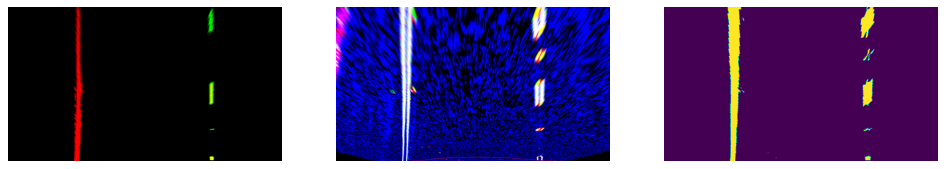

In [8]:
lane_filter_test('images/straight_lines1.jpg')

apply_sobel_mask와 sobel_breakdown 함수는 모두 Sobel 연산을 사용하여 이미지의 가장자리를 검출하지만, 그 목적과 출력 결과가 다릅니다.

apply_sobel_mask: 이 함수는 차선 검출을 위한 이진 마스크를 생성하는 것을 목표로 합니다. Sobel 연산 결과를 기반으로 미리 정의된 임계값들을 사용하여 차선 후보 영역을 이진 이미지(0 또는 1)로 나타냅니다. 즉, 차선일 가능성이 높은 픽셀은 1, 아닌 픽셀은 0으로 표시됩니다. 이 이진 마스크는 다른 이미지 처리 단계 (예: 색상 마스크와의 결합)에 사용됩니다. 결과는 단일 채널 이진 이미지입니다.

sobel_breakdown: 이 함수는 Sobel 연산의 중간 결과들을 시각화하기 위한 것입니다. apply_sobel_mask와 마찬가지로 Sobel 연산을 수행하지만, mag_thresh, x_thresh, grad_min, grad_max 각 조건을 만족하는 부분을 각각 다른 채널에 255(흰색)로 표시하여 RGB 이미지로 출력합니다. 이를 통해 각 임계값 조건이 이미지에 어떻게 영향을 주는지 시각적으로 분석할 수 있도록 합니다. 결과는 3채널 RGB 이미지입니다.

요약하면:

특징	apply_sobel_mask	sobel_breakdown
목적	차선 검출을 위한 이진 마스크 생성	Sobel 연산 결과 시각화
출력	단일 채널 이진 이미지 (0 또는 1)	3채널 RGB 이미지
사용 용도	차선 검출 파이프라인의 한 단계	디버깅 및 분석을 위한 시각화 도구
sobel_breakdown 함수는 apply_sobel_mask 함수의 동작을 이해하고 디버깅하는 데 도움을 주는 보조적인 함수라고 볼 수 있습니다. 실제 차선 검출에는 apply_sobel_mask의 결과가 사용되고, sobel_breakdown은 개발 과정에서 각 Sobel 조건들의 효과를 확인하기 위해 사용됩니다.

np.dstack((b1, b2, b3))는 NumPy의 dstack 함수를 사용하여 세 개의 2차원 배열 (b1, b2, b3)을 깊이(depth) 방향으로 쌓아 하나의 3차원 배열을 만드는 코드입니다.

좀 더 자세히 설명하면:

b1, b2, b3는 각각 차원이 (높이, 너비)인 2차원 NumPy 배열입니다. sobel_breakdown 함수 내부에서 각각 Sobel 연산의 세 가지 조건(magnitude, x-gradient, gradient angle)을 만족하는 픽셀들을 표시하는 이진 마스크입니다.

np.dstack 함수는 이 세 개의 2차원 배열을 새로운 차원(깊이)을 추가하여 하나의 3차원 배열로 결합합니다. 결과 배열의 차원은 (높이, 너비, 3)이 되며, 이는 RGB 이미지를 나타내는 표준적인 형태입니다. 각 채널(R, G, B)은 b1, b2, b3 중 하나에 해당합니다.

예를 들어,

b1이 빨간색 채널(R)의 정보를 가지고 있다면,

b2가 초록색 채널(G)의 정보를 가지고 있다면,

b3가 파란색 채널(B)의 정보를 가지고 있다면,

np.dstack((b1, b2, b3))는 이 세 채널을 합쳐 하나의 RGB 이미지를 생성합니다. 이렇게 생성된 RGB 이미지는 Sobel 연산의 각 조건이 이미지에 어떻게 적용되는지를 시각적으로 확인할 수 있도록 합니다. 즉, 각 채널은 특정 Sobel 조건을 만족하는 영역을 흰색으로 표시하고, 그렇지 않은 영역은 검은색으로 표시하는 역할을 합니다.

결론적으로, np.dstack은 2차원 이진 마스크들을 3차원 RGB 이미지로 변환하여 시각화를 용이하게 하는 역할을 합니다.


roi 함수는 **Region of Interest (관심 영역)**을 설정하는 역할을 합니다. 이미지 전체를 처리하는 대신, 차선이 존재할 가능성이 높은 특정 영역만을 선택적으로 처리하여 계산량을 줄이고, 노이즈로 인한 오류를 줄이는 데 사용됩니다.

roi 함수의 동작을 자세히 살펴보면:

def roi(gray, mn = 125, mx = 1200):
  m = np.copy(gray) + 1  # 입력 이미지의 복사본 생성 ( +1은 0값을 방지하기 위한 것으로 보임)
  m[:, :mn] = 0         # 이미지의 왼쪽 mn 픽셀을 0으로 설정 (검은색으로 만듬)
  m[:, mx:] = 0         # 이미지의 오른쪽 mx 픽셀을 0으로 설정 (검은색으로 만듬)
  return m             # 수정된 이미지 반환
Use code with caution.
Python
gray: 입력 이미지 (보통 회색조 이미지).

mn: 왼쪽에서 잘라낼 픽셀 수 (기본값 125).

mx: 오른쪽에서 잘라낼 픽셀 수 (기본값 1200).

함수는 입력 이미지의 왼쪽 mn 픽셀과 오른쪽 mx 픽셀을 검은색(0)으로 설정합니다. 즉, 이미지의 중앙 부분만 남기고 양쪽 가장자리를 제거합니다. 차선은 일반적으로 이미지의 중앙 부분에 위치하므로, 불필요한 영역을 제거하여 처리 속도를 높이고, 주변의 노이즈나 다른 물체로 인한 오류를 방지하는 효과를 얻을 수 있습니다.

요약: roi 함수는 이미지의 관심 영역을 제한하여 계산 효율을 높이고 노이즈의 영향을 줄이는 전처리 단계로 사용됩니다. mn과 mx 파라미터는 이미지의 크기와 차선의 위치에 따라 조정해야 합니다.